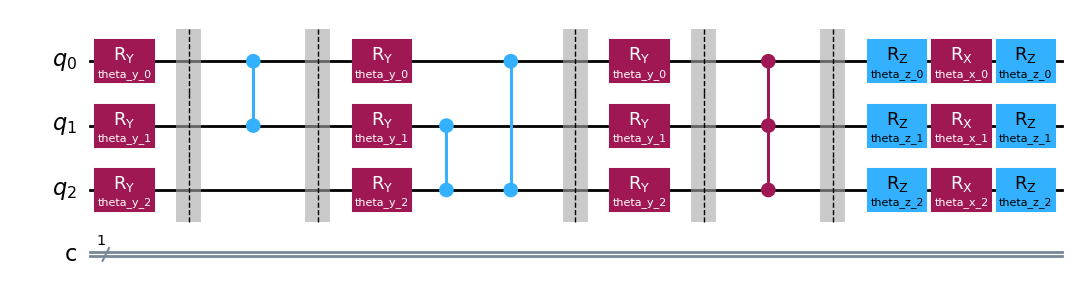

In [15]:
from qiskit import QuantumCircuit, transpile 
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler
from qiskit.circuit.library import MCMT
import numpy as np
from matplotlib import pyplot as plt

# Số qubit
n = 3

# Định nghĩa các tham số cho các cổng xoay Rx, Ry, Rz cho từng qubit
params_x = [Parameter(f'theta_x_{i}') for i in range(n)]
params_y = [Parameter(f'theta_y_{i}') for i in range(n)]
params_z = [Parameter(f'theta_z_{i}') for i in range(n)]

# Tạo mạch lượng tử
qc = QuantumCircuit(n, 1)

# Phần |g₂⟩: Sử dụng cổng Ry và CZ
for i in range(n):
    qc.ry(params_y[i], i)

qc.barrier()
i = 0
while i < n - 1:
    qc.cz(i, i + 1)
    i += 2

qc.barrier()
for i in range(n):
    qc.ry(params_y[i], i)

j = 1
while j < n - 1:
    qc.cz(j, j + 1)
    j += 2

qc.cz(n - 1, 0)  # Kết nối qubit cuối với qubit đầu tiên
qc.barrier()

# Phần |gₙ⟩: Sử dụng cổng Ry
for i in range(n):
    qc.ry(params_y[i], i)

qc.barrier()

# Thêm cổng MCMT CZ cho |gₙ⟩
mcmt_circuit = MCMT('cz', (n - 1), 1)
qc = qc.compose(mcmt_circuit, qubits=range(n))

qc.barrier()

# Phần W: Sử dụng cổng Rz và Rx
for i in range(n):
    qc.rz(params_z[i], i)
    qc.rx(params_x[i], i)
    qc.rz(params_z[i], i)

qc.draw('mpl')

In [16]:
# # Hàm tính xác suất đo trạng thái |1> trên qubit đầu tiên
# from qiskit.providers.basic_provider import BasicProvider
# from qiskit.visualization import plot_histogram

# basis_gates=['u3', 'cx']
# def loss(qc, params, n):
#     qc.measure(0, 0)
#     qc=qc.assign_parameters(params)
#     transpiled_qc = transpile(qc,basis_gates=basis_gates)  
#     backend = BasicProvider().get_backend('basic_simulator')
#     result = backend.run (transpiled_qc, shots=1000).result()
#     counts = result.get_counts()
  
#     decimal_counts = {}
#     for key, value in counts.items():
#         decimal_key = int(key, 2)  # Chuyển đổi chuỗi nhị phân thành số thập phân
#         decimal_counts[decimal_key] = value

#     # Xác suất đo trạng thái |1> trên qubit đầu tiên
#     p1 = decimal_counts.get(1, 0) / 1000
#     return p1

In [17]:
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler


def loss(qc, params, n):
    # # Gán tham số vào mạch
    qc = qc.assign_parameters(params)
    
    # Thêm phép đo vào qubit đầu tiên
    qc.measure(0, 0)
    
    # Khởi tạo Sampler và chạy mạch
    sampler = Sampler()
    job = sampler.run(qc, shots=1000)
    result = job.result()
    
    # Lấy phân phối xác suất
    quasi_dist = result.quasi_dists[0]
    
    # Tính xác suất đo được |1> trên qubit đầu tiên
    p1 = quasi_dist.get(1, 0)
    
    return p1


In [18]:
# Hàm tính gradient sử dụng parameter-shift rule
def parameter_shift_gradient(qc, params, param_key):
    shift = np.pi / 2
    # Tạo các bộ giá trị tham số với độ lệch
    params_plus = params.copy()
    params_minus = params.copy()
    params_plus[param_key] += shift
    params_minus[param_key] -= shift
    # Tính gradient
    grad = 0.5 * (loss(qc, params_plus, n) - loss(qc, params_minus, n))
    return grad

In [19]:
# Khởi tạo giá trị tham số
param_values = np.random.uniform(0, 2 * np.pi, len(params_x) + len(params_y) + len(params_z))
learning_rate = 0.3
params = dict(zip(params_x + params_y + params_z, param_values))

In [20]:
# Tối ưu hóa tham số để kết quả đo trên dây đầu tiên là |0>
losses = []
for epoch in range(100):
    grads = {key: parameter_shift_gradient(qc, params, key) for key in params}
    # Cập nhật tham số
    for key, grad in grads.items():
        params[key] -= learning_rate * grad
    
    current_loss = loss(qc, list(params.values()), n)
    losses.append(current_loss)
    print(f"Epoch {epoch + 1}: Loss = {current_loss:.4f}")
    # Dừng nếu Loss gần 0
    if current_loss < 1e-4:
        break

C:\Users\admin\AppData\Local\Temp\ipykernel_7196\3333578373.py:13: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Epoch 1: Loss = 0.5360
Epoch 2: Loss = 0.5350
Epoch 3: Loss = 0.5280
Epoch 4: Loss = 0.5060
Epoch 5: Loss = 0.4770
Epoch 6: Loss = 0.4600
Epoch 7: Loss = 0.3920
Epoch 8: Loss = 0.3660
Epoch 9: Loss = 0.2880
Epoch 10: Loss = 0.2560
Epoch 11: Loss = 0.2350
Epoch 12: Loss = 0.1660
Epoch 13: Loss = 0.1680
Epoch 14: Loss = 0.1140
Epoch 15: Loss = 0.0940
Epoch 16: Loss = 0.0730
Epoch 17: Loss = 0.0640
Epoch 18: Loss = 0.0400
Epoch 19: Loss = 0.0450
Epoch 20: Loss = 0.0390
Epoch 21: Loss = 0.0280
Epoch 22: Loss = 0.0250
Epoch 23: Loss = 0.0190
Epoch 24: Loss = 0.0130
Epoch 25: Loss = 0.0160
Epoch 26: Loss = 0.0100
Epoch 27: Loss = 0.0120
Epoch 28: Loss = 0.0060
Epoch 29: Loss = 0.0040
Epoch 30: Loss = 0.0030
Epoch 31: Loss = 0.0050
Epoch 32: Loss = 0.0020
Epoch 33: Loss = 0.0010
Epoch 34: Loss = 0.0030
Epoch 35: Loss = 0.0010
Epoch 36: Loss = 0.0000



Các tham số tối ưu trên mạch:

Qubit 0:
  Ry: theta_y_0 = 6.2388
  Rz: theta_z_0 = -0.3976
  Rx: theta_x_0 = 0.0512

Qubit 1:
  Ry: theta_y_1 = 3.3370
  Rz: theta_z_1 = 5.7490
  Rx: theta_x_1 = 4.2701

Qubit 2:
  Ry: theta_y_2 = 0.3014
  Rz: theta_z_2 = 1.8032
  Rx: theta_x_2 = 2.1931

Mạch lượng tử sau khi gán tham số:


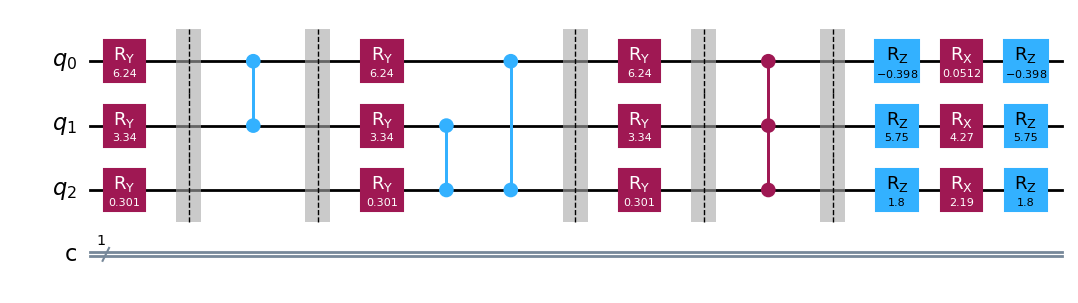

In [21]:
# Các tham số sau khi tối ưu hóa
print("\nCác tham số tối ưu trên mạch:")
for i in range(n):
    print(f"\nQubit {i}:")
    print(f"  Ry: theta_y_{i} = {params[params_y[i]]:.4f}")
    print(f"  Rz: theta_z_{i} = {params[params_z[i]]:.4f}")
    print(f"  Rx: theta_x_{i} = {params[params_x[i]]:.4f}")

# Hiển thị mạch với các tham số đã được gán
final_qc = qc.assign_parameters({param: value for param, value in params.items()})
print("\nMạch lượng tử sau khi gán tham số:")
final_qc.draw('mpl')


In [22]:


# # Hàm tính xác suất đo trạng thái |1> trên qubit đầu tiên
# from qiskit.providers.basic_provider import BasicProvider
# from qiskit.visualization import plot_histogram

# basis_gates=['u3', 'cx']
# def measure(final_qc, params, n):
#     final_qc.measure(0, 0)
#     transpiled_qc = transpile(final_qc,basis_gates=basis_gates)  
#     backend = BasicProvider().get_backend('basic_simulator')
#     result = backend.run (transpiled_qc, shots=1000).result()
#     counts = result.get_counts()
  
#     decimal_counts = {}
#     for key, value in counts.items():
#         decimal_key = int(key, 2)  # Chuyển đổi chuỗi nhị phân thành số thập phân
#         decimal_counts[decimal_key] = value

#     # # Xác suất đo trạng thái |1> trên qubit đầu tiên
#     # p1 = decimal_counts.get(1, 0) / 1000
#     return decimal_counts


In [23]:
# measure(final_qc, params, n)

In [24]:
# plot_histogram(measure(final_qc, params, n))

In [26]:
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram

final_qc.measure (0, 0)
# Khởi tạo Sampler và chạy mạch
sampler = Sampler()
job = sampler.run(final_qc, shots=1000)
result = job.result()\
#Lấy phân phối xác suất
quasi_dist = result.quasi_dists[0]
# Chuyển đổi kết quả thành định dạng phù hợp với plot_histogram
counts = {format(state, f'0{qc.num_qubits}b'): int(prob * 1000) for state, prob in quasi_dist.items()}

C:\Users\admin\AppData\Local\Temp\ipykernel_7196\3131173220.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


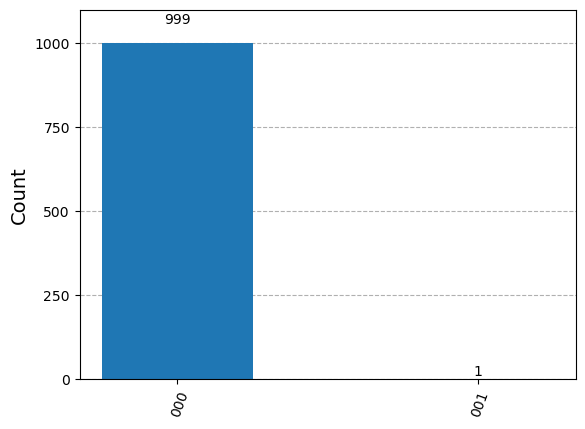

In [27]:
plot_histogram(counts)

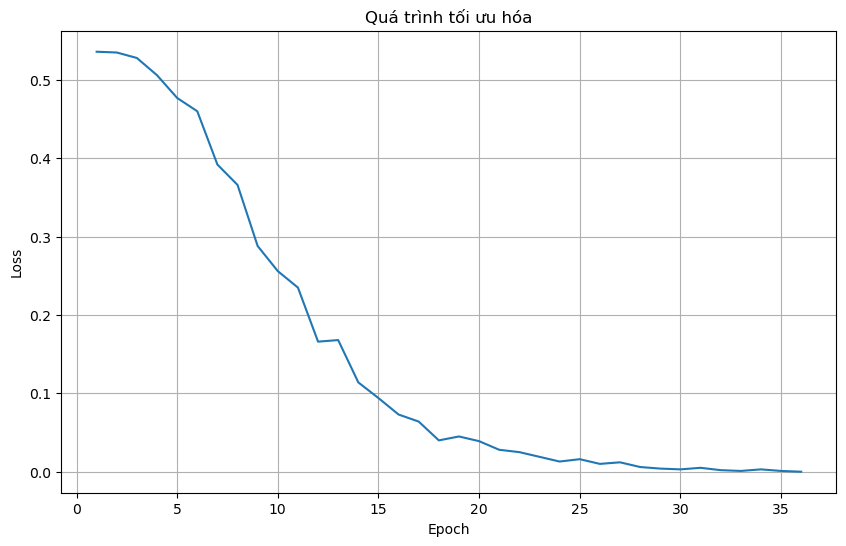

In [28]:
# Hiển thị kết quả training bằng đồ thị matplotlib
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses)
plt.title('Quá trình tối ưu hóa')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()